# data scraping

#### Outline:

#### 1. data about party funding
- parsing with tabula-package
- correct parsed tables manually

#### 2. filter financial data to decide on sample
- resulting dataframe: "finanz_data.obj" containing information regarding the statefunding for the next year (report 2018 means with "rate_next_year" the quarterly payment for the year 2019. 

#### 3. scrape twitter data

- resulting dataframe: "twitter_parties_1.obj" containing all tweets of the 14 parties that where:
- never part of the Bundestag
- received at some point state funding
- have a twitter account
- still exist
    
##### 4. narrow down sample based on twitter data
- resulting dataframe: "twitter_sample_1.obj" reduced down to 5 selected parties

#### 5. get more detailed finacial data from revenue reports of the respective parties
- resulting dataframe "acc_reports.obj" more detailed information about income and spendings of the parties

##### 6. gather election results data
- resulting dataframe: "elect_data.obj" percentage per party per election for all elections on eu, state and federal state level since 2011

In [5]:
############ packages

# general
from tqdm import tqdm
import numpy as np
import pandas as pd

import pickle

# 1.1 parsing with tabula
import tabula

# 1.2 correct parsed tables
import re

# 2 filter non parliment parties, get twitter handels
from collections import Counter

# 3 twitter scrape
import os
from datetime import date
import snscrape
import snscrape.modules.twitter as twitterScraper



from collections import Counter
import matplotlib.pyplot as plt

## 1 data about party funding

The reports regarding the statefunding are available from 2002 onwards on the website of the Bundestag (https://www.bundestag.de/parlament/praesidium/parteienfinanzierung/festsetz_staatl_mittel). Nevertheless, the availability is restricted to pdf files. Since it is only 18 initial files I downloaded them manually. 

Visually, the tables contained, seem to be standarized. After trying out differnt packages that promise the parsing of tables in pdf files to panda DataFrames, the package "tabula" has proven to be the one working best on the respective files. But the visual impression has prooven to be wrong - the parsed tables where different and false in a lot of ways. An extensive correction within python is necessary.



### 1.1 parsing with tabula

In [7]:
pdf_directory = "data/reports_state_funding/"

# make list to loop through for each file (filenames: finanz_XX-data, XX being the digits implying the report year)
filendings = ["0"+i if len(i)==1 else i for i in [str(i) for i in range(2,21)]]

# load tables in dictionary
tables_dict = {}

for i in tqdm(filendings):
    file = f"{pdf_directory}finanz_{i}-data.pdf"
    # read all tables per PDF
    tables_dict[int(i)] = tabula.read_pdf(file, pages="all", multiple_tables=True)
    
print(list(tables_dict.items())[0])

 37%|██████████████████████████████▌                                                    | 7/19 [00:15<00:27,  2.25s/it]Got stderr: Jan. 23, 2022 11:39:07 VORM. org.apache.pdfbox.pdmodel.font.PDFontFactory createFont
WARNUNG: Invalid font subtype 'COSName{}'
Jan. 23, 2022 11:39:07 VORM. org.apache.pdfbox.pdmodel.font.PDType1Font <init>
WARNUNG: Using fallback font ArialMT for MS Sans Serif

 42%|██████████████████████████████████▉                                                | 8/19 [00:17<00:25,  2.33s/it]Got stderr: Jan. 23, 2022 11:39:09 VORM. org.apache.pdfbox.pdmodel.font.PDFontFactory createFont
WARNUNG: Invalid font subtype 'COSName{}'
Jan. 23, 2022 11:39:09 VORM. org.apache.pdfbox.pdmodel.font.PDType1Font <init>
WARNUNG: Using fallback font ArialMT for MS Sans Serif

100%|██████████████████████████████████████████████████████████████████████████████████| 19/19 [00:54<00:00,  2.89s/it]

(2, [   Partei Bundestagswahl\r22.09.2002 Europawahl\r13.06.1999  \
0     NaN                Absolutin %            Absolutin %   

  Baden-Württemberg\r25.03.2001 Bayern\r13.09.1998 Berlin\r21.10.2001  \
0                   Absolutin %        Absolutin %        Absolutin %   

  Brandenburg\r05.09.1999 Bremen\r06.06.1999 Hamburg\r23.09.2001  \
0             Absolutin %        Absolutin %         Absolutin %   

  Hessen\r07.02.1999 Mecklenburg-Vorpommern\r22.09.2002  
0        Absolutin %                        Absolutin %  ,                      SPD  18.488.66838,52%   8.307.08530,70%  1.508.35833,29%  \
0                    CDU  14.167.56129,52%  10.628.22439,28%  2.029.80644,80%   
1                    CSU    4.315.0808,99%    2.540.0079,39%              NaN   
2                  GRÜNE    4.110.3558,56%    1.741.4946,44%     350.3837,73%   
3                    FDP    3.538.8157,37%      820.3713,03%     367.5808,11%   
4                    PDS    1.916.7023,99%    1.567.7455,79%  

### 1.2 correct parsed tables

Since the parsing ends up in severe irregularities and most of the data we might not need for this project, i will for now only finalize the parsing for the last table that contains which parties receive what support in general and how high it is. Based on this data one generate a first party sample (the ones that received party funding somewhen since 2002).

The reports contain several tables where only the table on the last page is the one I am interested in. Since the reports are differently parsed and have different page numbers it was not possible to only extract that one table.


In [8]:
# through manual checking we know at which position the right table is, depending on the year

# we get these ones into one dictionary
## the table in question is for most reports the last table, except the years 2017,18 and 19
table_dict = {k:(v[-1] if k not in [17,18,19] else v[-2]) for (k,v) in tables_dict.items()}

# set up a vector for collumn names for the standartized table
col_titles = ["party","share_state","rest_prev_year","final_payment_prev_year",
             "rate_new_year"]

In [9]:
## group tables manually based on their issues to solve them efficiently

# tables 2-7,10,16 have the same problems
# 8 differently (title for last collumn moved one column to far)
# 9 the last two column names moved one column further
# 11 and 12 - last column moved one col to far
# 14 and 15 a lot of stuff 
# 17 and 18 a  lot of stuff 
# 19 mostly good
# 20 a lot stuff but IS last table


### set up helper funtions for corrections
def correct_table(table):
    '''
    corrects tables with cartain parsing errors:
    - 2 rows at the top to much, to many cols
    - all col values in one cell seperated with "/r"
    - adjust collumn names
    '''
    new_table = table.iloc[2:,:5]
    new_cols = {"party":new_table.iloc[:,0]}
    
    # loop through columns and set correct collumn titels and correct collumn content
    for i in range(1,5):
        new_cols[col_titles[i]] = new_table.iloc[0,i].split("\r")
        new_cols[col_titles[i]].append(new_table.iloc[-1,i])
    return pd.DataFrame(new_cols)


def correct_table_2020(table):
    '''
    adresses specifically the parsing errors of the 2020 table
    '''
    new_table = table.iloc[2:,:5]
    new_cols = {"party":new_table.iloc[:,0]}
    
    for i in range(1,5):
        new_col = new_table.iloc[0,i].split("\r")
        new_col.append(new_table.iloc[-1,i])
        if i >= 3:
            new_cols[col_titles[i]]=new_col[:9]+[np.nan]+new_col[9:]
        else:
            new_cols[col_titles[i]] = new_col
    
    return pd.DataFrame(new_cols)

In [10]:
# fix issues, align table formats

# manual fixes wihtout defining helper function
table_dict[8] = table_dict[8].rename(columns={"Unnamed: 0": "rate_new_year"}).iloc[:,:-1]

table_dict[9] = table_dict[9].rename(columns={"Unnamed: 0": "final_payment_prev_year", 
                                              "Schlusszahlung/\rRückforderung für 2009": "rate_new_year"}).iloc[:,:-1]
table_dict[11] = table_dict[11].drop("Unnamed: 0", axis=1)
table_dict[12] = table_dict[12].drop("Unnamed: 0", axis=1)

table_dict[15] = table_dict[15].rename(columns={"Unnamed: 0":"party",
                              "Unnamed: 2":"share_state",
                              "Unnamed: 3": "rest_prev_year",
                              "Unnamed: 4": "final_payment_prev_year",
                              "Höhe der einzelnen":"rate_new_year"}).drop("Unnamed: 1", axis=1).iloc[9:,:].drop(21,axis=0)


# more complex issues - use functions
table_dict[14] = table_dict[14].drop("Unnamed: 1",axis=1)
table_dict[14] = correct_table(table_dict[14])

table_dict[17] = table_dict[17].drop(["Unnamed: 0", "Unnamed: 2"],axis=1)
table_dict[17] = correct_table(table_dict[17])

table_dict[18] = table_dict[18].drop(["Unnamed: 0", "Unnamed: 1"],axis=1)
table_dict[18] = correct_table(table_dict[18])

table_dict[20] = table_dict[20].drop(["Unnamed: 0", "Unnamed: 1"],axis=1)
table_dict[20] = correct_table_2020(table_dict[20])

In [11]:
# adjust 

# drop the first two rows in all tables where needed
table_dict_2 = {k:(v.drop([0,1],axis=0)if k in [2,3,4,5,6,7,8,9,10,11,12,13,16,19] else v) for k,v in table_dict.items()}
table_dict_2[20].head()

,party,share_state,rest_prev_year,final_payment_prev_year,rate_new_year
2,1)\rCDU,"48.850.162,71","42.127.455,16","6.722.707,55","2.677.000,00"
3,SPD,"49.879.078,91","51.212.981,44","- 1.333.902,53","12.469.769,73"
4,GRÜNE,"22.841.953,77","21.262.989,52","1.578.964,25","5.710.488,44"
5,AfD,"9.290.136,62","7.694.174,96","1.595.961,66","2.322.534,16"
6,FDP,"14.130.047,11","13.848.084,88","281.962,23","3.532.511,78"


In [12]:
# set correct titels for all tables
for k,v in table_dict_2.items():
    table_dict_2[k].set_axis(col_titles, axis=1, inplace=True)
    
    
# some party names seem to be still false e.g. "1)\rCDU" instead of CDU
# adjust party names

def clean_party_name(s):
    '''
    clean text input with regx expressions
    '''
    output = re.sub(r"\d*\)"," ",s)
    return output.strip(" ").strip("\r")

# apply cleaning function
for k,v in table_dict_2.items():
    table_dict_2[k].party = [clean_party_name(c) for c in table_dict_2[k].party]

In [13]:
# adjust party names further (different names for similar parties)


party_names = {"Die Tierschutzpartei": "Tierschutzpartei",
              "ödp":"ÖDP",
               "Die Linke.":"DIE LINKE",
               "Die PARTEI":"DIE PARTEI",
               "BVB/Freie Wähler":"BVB/FREIE WÄHLER",
               "AFD":"AfD",
               "FW FREIE WÄHLER":"FREIE WÄHLER",
               "FW-SH":"FW Schleswig-Holstein",
               "LKR (ex. ALFA":"LKR"
              }

for k,_ in table_dict_2.items():
    new_col = []
    for p in list(table_dict_2[k].party):
        if p in party_names.keys():
            new_col.append(party_names[p])
        else:
            new_col.append(p)
    table_dict_2[k].party = new_col

In [14]:
# set up year column for each table and concat all tables into one dataframe

table_dict_2[2]["year"] = 2002
data = table_dict_2[2]

for k,v in table_dict_2.items():
    if k != 2:
        table = v
        if len(str(k)) == 1:
            table["year"] = int("200"+str(k))
            data = pd.concat([data,table], ignore_index=True)
        else:
            table["year"] = int("20"+str(k))
            data = pd.concat([data,table], ignore_index=True)
        

In [15]:
# test
data[data.party == "PIRATEN"]

,party,share_state,rest_prev_year,final_payment_prev_year,rate_new_year,year
152,PIRATEN,"0,00","0,00","0,00","0,00",2009
177,PIRATEN,"492.895,46","0,00","492.895,46","123.223,87",2010
199,PIRATEN,"331.238,05","492.895,48","- 161.657,43","82.809,51",2011
222,PIRATEN,"243.580,67","331.238,04","- 87.657,37","60.895,17",2012
244,PIRATEN,"1.063.061,20","243.580,68","819.480,52","265.765,30",2013
267,PIRATEN,"939.344,98","1.063.061,20","- 123.716,22","234.836,25",2014
288,PIRATEN,"242.755,26","939.345,00","- 696.589,74","60.688,82",2015
309,PIRATEN,"263.664,35","242.755,28","20.909,07","65.916,09",2016
333,PIRATEN,"587.660,39","263.664,36","323.996,03","146.915,10",2017
355,PIRATEN,"526.712,53","587.660,40","- 60.947,87","131.678,13",2018


In [16]:
# corrct number format
def clean_col(column):
    output = []
    for i in column:
        if type(i) != float:
            v = i.replace(".","").replace(",",".").replace(" ","")
            try:
                output.append(float(v))
            except:
                output.append(np.nan)
        else:
            output.append(i)
    return output

data.iloc[:,1:5] = data.iloc[:,1:5].apply(clean_col,axis=0)

In [18]:
# save finacial reports data

file = open("data/funding_data.obj","wb")
pickle.dump(data,file)
file.close()

## 2.filter financial data to find the parties we want to scrape on twitter

In [19]:
# first filter parties out that where part of parliment per year
# the respective file was build manually with information from the offical ressource:
# https://www.bundeswahlleiter.de/bundeswahlleiter.html

parliment_parties = pd.read_csv("data/fed_par_parties_ger.csv", sep=";")
parliment_parties.head(5)

,2002,2003,2004,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019,2020
0,SPD,SPD,SPD,SPD,SPD,SPD,SPD,SPD,SPD,SPD,SPD,SPD,SPD,SPD,SPD,CDU,CDU,CDU,CDU
1,CDU,CDU,CDU,CDU,CDU,CDU,CDU,CDU,CDU,CDU,CDU,CDU,CDU,CDU,CDU,SPD,SPD,SPD,SPD
2,CSU,CSU,CSU,CSU,CSU,CSU,CSU,CSU,CSU,CSU,CSU,CSU,CSU,CSU,CSU,GRÜNE,GRÜNE,GRÜNE,GRÜNE
3,GRÜNE,GRÜNE,GRÜNE,GRÜNE,GRÜNE,GRÜNE,GRÜNE,GRÜNE,GRÜNE,GRÜNE,GRÜNE,GRÜNE,GRÜNE,GRÜNE,GRÜNE,AFD,AFD,AFD,AFD
4,FDP,FDP,FDP,FDP,FDP,FDP,FDP,FDP,FDP,FDP,FDP,DIE LINKE,DIE LINKE,DIE LINKE,DIE LINKE,DIE LINKE,DIE LINKE,DIE LINKE,DIE LINKE


In [20]:
# remove bundestags parties for each year

# set up function to remove parliment parties from dataset per year
def remove_parties(df,df_bundestag):
    '''
    df - df from which corresponding parties are supposed to be removed
    df_bundestag - df containing information for which parties where when in the Bundestag
    filters per year for the parties in df that are not contained in the corresponding year_col of df_bundestag
    returns a df_bundestag without all rows that contained a bundestag_party for the corresponding year
    '''
    clean_ds = pd.DataFrame(columns=data.columns)
    
    for year in list(df_bundestag.columns):
        sub_ds = df[df["year"] == int(year)]
        sub_ds = sub_ds[~sub_ds.party.isin(df_bundestag.loc[:,year])]
        clean_ds = pd.concat([clean_ds,sub_ds])

    return clean_ds.reset_index()

# apply function
data_clean = remove_parties(data,parliment_parties)
data_clean.drop(columns=["index"],inplace=True)
data_clean.head()

,party,share_state,rest_prev_year,final_payment_prev_year,rate_new_year,year
0,REP,1241131.81,1550711.64,-309579.83,310282.95,2002
1,Schill,217318.62,0.00,217318.62,54329.66,2002
2,Tierschutzpartei,62082.92,46040.56,16042.36,15520.73,2002
3,ÖDP,410960.91,523409.92,-112449.01,102740.23,2002
4,DVU,281782.85,563479.00,-281696.15,70445.71,2002


In [30]:
# check number of unique parties
print(f"Unique parties whole data set: {len(data_clean.party.unique())}")

Unique parties whole data set: 41


German as a language on Twitter was introduced in Dezember 2009. Therefore, I only look at parties that where funded since 2010, The one month in decemeber would not be of much value for the analysis since I need yearly aggregated data.

- Source: https://blog.twitter.com/official/en_us/a/2009/was-gibts-neues.html
- results in 28 parties to possibly scrape

In [31]:
print(f"Unique parties since 2010: {len(data_clean[data_clean.year>= 2010].party.unique())}")

Unique parties since 2010: 28


In [35]:
data_clean[data_clean.year>= 2010].party.unique()

# we also see "Gesamt" which is not a party but the row per report that sums up the funding for all parties that year
# will be removed through further sub-setting - can be ignored

array(['PIRATEN', 'NPD', 'Tierschutzpartei', 'REP', 'FREIE WÄHLER',
       'FAMILIE', 'ÖDP', 'RENTNER', 'pro NRW', 'SSW', 'BP', 'DVU',
       'FW in Thüringen', 'Freie Sachsen', 'FW Brandenburg', 'Gesamt',
       'pro Deutschland', 'FW Schleswig-Holstein', 'FDP', 'AfD',
       'DIE PARTEI', 'BVB/FREIE WÄHLER', 'PRO NRW', 'LKR',
       'Graue Panther', 'Tierschutzallianz', 'Volt', 'Tierschutz hier!'],
      dtype=object)

#### look for the main twitter accounts of these 26 parties

- Piraten: @Piratenpartei                    
- NPD: @npdde
- Tierschutzpartei: @Tierschutzparte         
- Freie Wähler: @FREIEWAEHLER_BV      
- REP: @republikaner
- Familie: - only twitter account for single states
- ÖDP: @oedp_de                              
- Rentner: party does not exist anymore
- Pro NRW: party does not exist anymore
- SSW: @SSWpresse     
- DVU: no twitter Account and does not exist anymore
- BP: @Bayernpartei                          
- FW in Thüringen: regional branch of Freie Wähler
- Freie Sachsen: @freiesachsen_
- pro Deutschland: party does not exist anymore
- FW Schleswig-Holstein: regional party, for our purpose subdivision of Freie Wähler
- FDP: part of Bundestag before and later
- AfD: part of Bundestag later
- Die Partei: @DiePARTEI   
- BVB/Freie Wähler: regional party, for our purpose subdivision of Freie Wähler      
- Pro NRW: party does not exist anymore
- LKR: @LKR_Partei_Bund                      
- Graue panther: no account for state level
- Tierschutzallianz: @Allianz_MTN
- Volt: @VoltDeutschland                          
- Tierschutz hier!: @TierschutzH


Based on this avaialability check we can reduce the sample already further.
We only proceed with the parties that still exist and for which we can find a twitter account that is meant to adress federal state level issues (not only regional).

## 3. twitter data

The search for a package that allows the fetching tweets back to the first tweet ever published by a respective account took longer than expected. While the original twitter API does not promises the necessary features "twint" and "TwitterScraper" did so, but for different reasons they could not fetch the needed tweets. I finally found "snscrape" that seem to works as expected

- https://github.com/JustAnotherArchivist/snscrape

In [23]:
### possible endpoints of the snscrape API
#   url: str
# 	date: datetime.datetime
# 	content: str
# 	renderedContent: str
# 	id: int
# 	user: 'User'
# 	replyCount: int
# 	retweetCount: int
# 	likeCount: int
# 	quoteCount: int
# 	conversationId: int
# 	lang: str
# 	source: str
# 	sourceUrl: typing.Optional[str] = None
# 	sourceLabel: typing.Optional[str] = None
# 	outlinks: typing.Optional[typing.List[str]] = None
# 	tcooutlinks: typing.Optional[typing.List[str]] = None
# 	media: typing.Optional[typing.List['Medium']] = None
# 	retweetedTweet: typing.Optional['Tweet'] = None
# 	quotedTweet: typing.Optional['Tweet'] = None
# 	inReplyToTweetId: typing.Optional[int] = None
# 	inReplyToUser: typing.Optional['User'] = None
# 	mentionedUsers: typing.Optional[typing.List['User']] = None
# 	coordinates: typing.Optional['Coordinates'] = None
# 	place: typing.Optional['Place'] = None
# 	hashtags: typing.Optional[typing.List[str]] = None
# 	cashtags: typing.Optional[typing.List[str]] = None

In [37]:
# define helper function to scrape all tweets of a respective user

def scrape_user_to_df(user, col):
    '''
    input: usertag and columns that you be consisten in the output dataframe
    return: pandas dataframe containing all tweets that are still availavle for that user
    
    scrapes tweet by tweet for a defined users and returns tweets as dataframe (rowwise)
    '''
    scraper = twitterScraper.TwitterUserScraper(user, False)
    out_df = pd.DataFrame(columns=col)

    for i,tweet in enumerate(scraper.get_items()):
        row = [tweet.date, tweet.content, tweet.renderedContent,tweet.id, tweet.user,tweet.replyCount,
              tweet.retweetCount, tweet.likeCount, tweet.quoteCount, tweet.mentionedUsers, tweet.hashtags,
              tweet.cashtags, tweet.media, tweet.outlinks, tweet.retweetedTweet,tweet.quotedTweet, tweet.inReplyToTweetId]
        out_df.loc[i] = row
        
        # print out every 1000 tweets to check progress
        if i%1000 == 0:
            print(i, tweet.date)
    return out_df

# def function to scrape all tweets of multiple users and return a dataframe
def scrape_multiple_users(list_users):
    '''
    takes a list of users and applies the scrape_user_to_df function to each of them wiht the columns defined in the function
    appens the resulting user-dataframes and returns one dataframe containing all tweets of all users
    '''
    col = ["date","content","renderedContent", "id","user","replyCount",
          "retweetCount", "likeCount","quoteCount","mentionedUsers", "hashtags",
          "cashtags","media", "outlinks","retweetedTweet","quotedTweet","inReplyToTweetId"]
    out_df = pd.DataFrame(columns=col)
    for u in tqdm(list_users):
        df_temp = scrape_user_to_df(u, col)
        out_df = pd.concat([out_df,df_temp],ignore_index=True)
        
        print(f"{u} scraped.")
    return out_df

In [38]:
#  set up list of all found twitter accounts of parties that where never part of the Bundestag
party_list = ["FREIEWAEHLER_BV","DiePARTEI","Tierschutzparte","oedp_de","Piratenpartei","VoltDeutschland","Bayernpartei",
 "BVBFW","FREIEWAEHLER_BV","LKR_Partei_Bund","SSWpresse","npdde","TierschutzH","Allianz_MTN","republikaner",
 "freiesachsen_"]

In [39]:
# scrape twitter data, commented out - needed data is in the repro and will be loaded where necessary

#data_complete = scrape_multiple_users(party_list)

# load twitter data
with open("data/twitter_scraped.obj", "rb") as f:
    df_twitter = pickle.load(f)

  0%|                                                                                           | 0/16 [00:00<?, ?it/s]

0 2022-01-21 18:32:30+00:00


  6%|█████▏                                                                             | 1/16 [00:21<05:16, 21.12s/it]

FREIEWAEHLER_BV scraped.
0 2022-01-17 11:08:31+00:00
1000 2019-04-17 20:20:13+00:00
2000 2010-12-05 16:25:05+00:00


 12%|██████████▍                                                                        | 2/16 [01:17<09:49, 42.07s/it]

DiePARTEI scraped.
0 2022-01-22 17:44:12+00:00
1000 2020-08-18 16:08:08+00:00
2000 2019-09-02 09:45:52+00:00
3000 2018-08-25 20:32:01+00:00
4000 2014-06-13 15:42:55+00:00
5000 2013-09-29 08:58:44+00:00
6000 2013-09-06 06:29:05+00:00
7000 2013-08-21 10:59:04+00:00


 19%|███████████████▍                                                                  | 3/16 [04:10<22:00, 101.57s/it]

Tierschutzparte scraped.
0 2022-01-22 21:54:05+00:00
1000 2019-07-15 15:24:00+00:00
2000 2017-05-09 07:45:32+00:00
3000 2015-06-05 12:55:34+00:00
4000 2014-05-05 06:36:35+00:00


 25%|████████████████████▌                                                             | 4/16 [06:03<21:13, 106.09s/it]

oedp_de scraped.
0 2022-01-20 16:05:11+00:00
1000 2021-06-11 22:08:11+00:00
2000 2021-03-14 21:58:13+00:00
3000 2020-12-31 21:38:40+00:00
4000 2020-09-24 07:09:38+00:00
5000 2020-05-13 16:43:31+00:00
6000 2019-12-06 19:22:27+00:00
7000 2019-07-16 19:04:51+00:00
8000 2019-04-17 15:43:37+00:00
9000 2019-03-18 06:23:41+00:00
10000 2019-02-16 20:00:49+00:00
11000 2018-09-16 13:00:00+00:00
12000 2018-03-25 08:00:02+00:00
13000 2017-09-23 15:00:01+00:00
14000 2017-05-02 20:20:45+00:00
15000 2016-11-02 12:22:05+00:00
16000 2015-08-04 16:34:07+00:00
17000 2014-12-01 20:34:33+00:00
18000 2014-06-23 16:00:08+00:00
19000 2013-11-30 10:57:06+00:00
20000 2013-06-12 11:59:52+00:00
21000 2012-12-10 21:05:57+00:00
22000 2012-03-28 09:38:25+00:00
23000 2011-05-14 16:26:07+00:00
24000 2010-11-30 10:11:41+00:00
25000 2010-07-04 22:50:59+00:00
26000 2010-04-15 10:08:29+00:00
27000 2010-01-19 15:38:41+00:00
28000 2009-09-29 17:41:19+00:00
29000 2009-07-13 14:56:26+00:00
30000 2009-05-30 10:22:09+00:00
3100

 31%|█████████████████████████                                                       | 5/16 [19:21<1:05:12, 355.72s/it]

Piratenpartei scraped.
0 2022-01-21 10:48:52+00:00
1000 2020-01-28 17:00:01+00:00
2000 2019-06-10 07:26:10+00:00
3000 2019-03-04 19:20:45+00:00


 38%|██████████████████████████████▊                                                   | 6/16 [20:59<44:40, 268.05s/it]

VoltDeutschland scraped.
0 2022-01-23 07:53:54+00:00
1000 2021-01-24 15:19:59+00:00
2000 2019-04-24 19:51:12+00:00
3000 2018-06-21 12:33:06+00:00
4000 2017-10-29 15:59:50+00:00
5000 2017-08-23 17:58:01+00:00
6000 2017-02-22 14:45:16+00:00
7000 2016-06-28 05:15:39+00:00
8000 2013-12-06 17:21:44+00:00
9000 2011-03-11 15:52:33+00:00


 44%|███████████████████████████████████▉                                              | 7/16 [24:36<37:43, 251.50s/it]

Bayernpartei scraped.
0 2021-12-24 09:42:55+00:00
1000 2019-09-02 12:06:33+00:00
2000 2017-03-16 13:59:48+00:00
3000 2016-06-07 16:15:46+00:00
4000 2015-08-11 14:34:38+00:00


 50%|█████████████████████████████████████████                                         | 8/16 [26:39<28:03, 210.38s/it]

BVBFW scraped.
0 2022-01-21 18:32:30+00:00


 56%|██████████████████████████████████████████████▏                                   | 9/16 [26:58<17:35, 150.73s/it]

FREIEWAEHLER_BV scraped.
0 2021-11-30 10:19:47+00:00


 62%|██████████████████████████████████████████████████▋                              | 10/16 [27:09<10:44, 107.42s/it]

LKR_Partei_Bund scraped.
0 2021-12-16 13:36:54+00:00
1000 2014-04-03 09:59:46+00:00


 69%|████████████████████████████████████████████████████████▍                         | 11/16 [27:33<06:50, 82.12s/it]

SSWpresse scraped.
0 2022-01-23 05:13:19+00:00


 75%|█████████████████████████████████████████████████████████████▌                    | 12/16 [27:47<04:05, 61.25s/it]

npdde scraped.
0 2020-09-14 11:15:16+00:00


 81%|██████████████████████████████████████████████████████████████████▋               | 13/16 [27:53<02:13, 44.37s/it]

TierschutzH scraped.
0 2021-12-24 12:00:50+00:00
1000 2018-03-22 13:12:10+00:00
2000 2016-09-26 13:30:13+00:00


 88%|███████████████████████████████████████████████████████████████████████▊          | 14/16 [28:54<01:38, 49.39s/it]

Allianz_MTN scraped.
0 2019-04-26 23:32:25+00:00
1000 2017-05-26 11:24:29+00:00
2000 2015-12-06 20:56:38+00:00
3000 2015-02-10 10:37:38+00:00
4000 2010-12-06 12:37:58+00:00


 94%|████████████████████████████████████████████████████████████████████████████▉     | 15/16 [30:28<01:02, 62.96s/it]

republikaner scraped.
0 2022-01-23 09:47:30+00:00


100%|█████████████████████████████████████████████████████████████████████████████████| 16/16 [30:48<00:00, 115.53s/it]

freiesachsen_ scraped.


In [40]:
data_complete.head() # check fetched data

,date,content,renderedContent,id,user,replyCount,retweetCount,likeCount,quoteCount,mentionedUsers,hashtags,cashtags,media,outlinks,retweetedTweet,quotedTweet,inReplyToTweetId
0,2022-01-21 18:32:30+00:00,@kineyDE Bei der Formulierung kommt es auf die...,@kineyDE Bei der Formulierung kommt es auf die...,1484594769892413442,https://twitter.com/FREIEWAEHLER_BV,1,0,0,0,[https://twitter.com/kineyDE],None,None,None,None,None,None,1484583320331632647
1,2022-01-21 17:42:48+00:00,"@_paulquappe_ Deswegen: Faire Entlohnung, Rent...","@_paulquappe_ Deswegen: Faire Entlohnung, Rent...",1484582263782350866,https://twitter.com/FREIEWAEHLER_BV,0,0,0,0,[https://twitter.com/_paulquappe_],None,None,None,[https://www.freiewaehler.eu/unsere-politik/wa...,None,None,1484574786655240197
2,2022-01-21 17:40:15+00:00,@kineyDE Wer spricht denn hier von Sklaverei? ...,@kineyDE Wer spricht denn hier von Sklaverei? ...,1484581620006936585,https://twitter.com/FREIEWAEHLER_BV,1,0,0,0,[https://twitter.com/kineyDE],None,None,None,[https://www.freiewaehler.eu/unsere-politik/wa...,None,None,1484574347394170888
3,2022-01-21 15:54:59+00:00,Dieser Dienst für die Gemeinschaft muss sich f...,Dieser Dienst für die Gemeinschaft muss sich f...,1484555129378553857,https://twitter.com/FREIEWAEHLER_BV,0,1,3,0,None,None,None,None,None,None,None,1484555127449083907
4,2022-01-21 15:54:58+00:00,Wir fordern deshalb ein #Gesellschaftsjahr für...,Wir fordern deshalb ein #Gesellschaftsjahr für...,1484555127449083907,https://twitter.com/FREIEWAEHLER_BV,1,1,6,0,None,"[Gesellschaftsjahr, Bundeswehr, Katastrophensc...",None,None,None,None,None,1484555125637136387


In [42]:

#save once fetched so we dont need to fetch the data again

# with open("data/twitter_scraped.obj", "wb") as f:
#     pickle.dump(data_complete, f)

## 4. Narrow down sample based on twitter data

In [46]:
# load twitter data
with open("data/twitter_scraped.obj", "rb") as f:
    df_twitter = pickle.load(f)


### 4.1 explore number of tweets over time

In [47]:
# number of tweets per party
df_twitter.user = df_twitter.user.apply(str) # for further usage turn userlink into string
Counter(df_twitter.user.apply(str))

# Observation: some parties got very few tweets in total, to sparse for analysis
### npd, LKR, TierschutzH, freiesachsen_

Counter({'https://twitter.com/FREIEWAEHLER_BV': 1618,
         'https://twitter.com/DiePARTEI': 2347,
         'https://twitter.com/Tierschutzparte': 7742,
         'https://twitter.com/oedp_de': 4882,
         'https://twitter.com/Piratenpartei': 31116,
         'https://twitter.com/VoltDeutschland': 3599,
         'https://twitter.com/Bayernpartei': 9442,
         'https://twitter.com/BVBFW': 4416,
         'https://twitter.com/LKR_Partei_Bund': 450,
         'https://twitter.com/SSWpresse': 1102,
         'https://twitter.com/npdde': 467,
         'https://twitter.com/TierschutzH': 218,
         'https://twitter.com/Allianz_MTN': 2814,
         'https://twitter.com/republikaner': 4399,
         'https://twitter.com/freiesachsen_': 710})

<AxesSubplot:xlabel='date'>

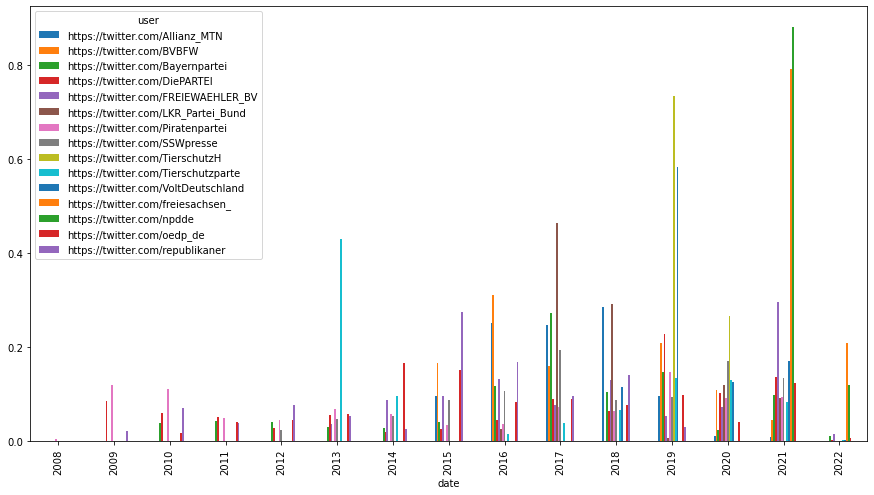

In [49]:
# plotting to get a visual impression

fig, ax = plt.subplots(figsize=(15,8))

f = df_twitter.groupby(['date', 'user']).size().unstack()
f["date"] = [pd.to_datetime(i) for i in f.index]
f_2 = f.groupby(f["date"].dt.year).count()
f_2.update(f_2.div(f_2.sum(axis=0),axis=1))
f_2.drop(labels=["date"], axis=1).plot(kind="bar",ax=ax) 
#plot fractional to get a better impression an to let absolute numbers not influence judgement

#### Observations
Until now the financial data is only available until 2020. The financial data is furthermore yearly, therefore we need to aggregate the twitter data yearly. Since we need as many datapoints to robustly check for correlations we want as many years as possible.

Therefore, the following parties will be discared due to being on twitter for not long enough/ havig deleted everything before:
- TierschutzH(only active since 2019),
- freiesachsen_(only 2021),
- npd(only 2021), 
- volt(only since 2018)


In [50]:
# remove parties
parties_to_remove = ["https://twitter.com/TierschutzH","https://twitter.com/freiesachsen_",
                    "https://twitter.com/npdde","https://twitter.com/VoltDeutschland"]

df_filtered = df_twitter[~df_twitter["user"].isin(parties_to_remove)]

<AxesSubplot:xlabel='date'>

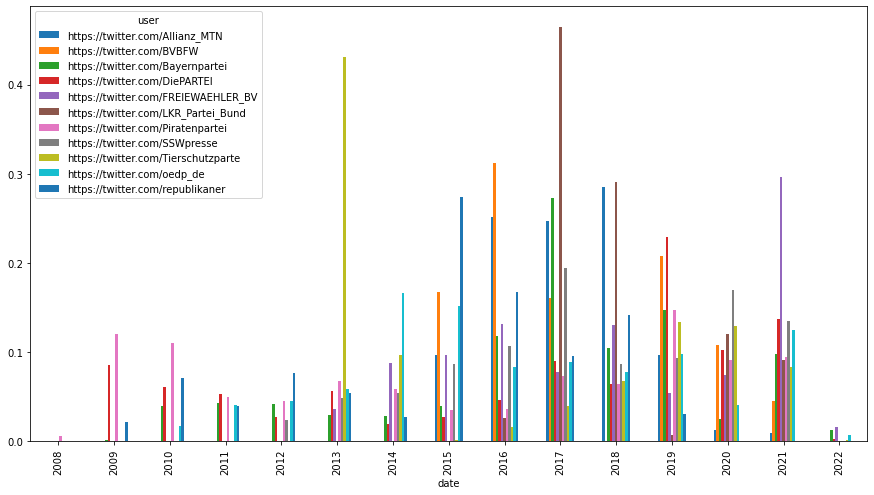

In [51]:
# plot again filtered df
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(15,8))
f = df_filtered.groupby(['date', 'user']).size().unstack()
f["date"] = [pd.to_datetime(i) for i in f.index]
f_2 = f.groupby(f["date"].dt.year).count()
f_2.update(f_2.div(f_2.sum(axis=0),axis=1))
f_2.drop(labels=["date"], axis=1).plot(kind="bar",ax=ax) 

#### Observations

- general lack of data for most parties before 2013
- 5 parties have a stable tweetcount from 2010 on
- choosen parties must have been active throughout the start year > half a year would result in a biased yearly aggregation > start year 2011

- Reduce the party sample to such parties that are active since 2010:
['https://twitter.com/DiePARTEI','https://twitter.com/Bayernpartei','https://twitter.com/Piratenpartei', 
#'https://twitter.com/oedp_de', 'https://twitter.com/republikaner']

- current timeframe 2011-2020

### 4.2 explore compariability of sample regarding election participation

##### - "DiePartei"
- federal elect 2013: 0,18%, 
- federal elect 2017: 0,98%, 
- federal elect 2021: 0,99%
- eu elect 2014: 0.63%
- eu elect 2019; 2.4%

#### - "OEDP" 
- federal elect 2013: 0.3%
- federal elect 2017: 0.3%
- federal elect 2021: 0.2%
- eu elect 2014: 0.6%, 
- eu elect 2019: 1.0%

#### "Piratenpartei" 
- federal elect 2013: 2.2%
- federal elect 2017: 0.4%, 
- feder elect 2021: 0.4%
- eu elect 2014: 1.4%
- eu 2019: 0.7%

#### "Bayernpartei" (results = fraction of votes in bavaria, they only run in bavaria for the respective elections)
- federal elect 2013: 0.9%
- federal elect 2017: 0.8%
- federal elect 2021: 0.4%
- eu elect 2014: 1.3%
- eu elect 2019: 0.9%

#### "republikaner"
- federal elect 2013: 0.2%, 
- federal elect 2017/2021: not running
- eu elect 2013: 0.2
- eu elect 2019: not running

4 of the 5 parties participated in all election on the eu and state level since 2011. While the "Republikaner" did not. We keep them in the sample for the moment being to ideally profit from the twitter data they contribute.
The "Bayernpartei" participated in all election but was only running in one federal state (Bavaria). Might be important to keep in mind.



In [52]:
# remove all other parties
parties_to_remove_2 = ["https://twitter.com/BVBFW","https://twitter.com/LKR_Partei_Bund",
                    "https://twitter.com/SSWpresse","https://twitter.com/Allianz_MTN",
                      'https://twitter.com/FREIEWAEHLER_BV', 'https://twitter.com/Tierschutzparte']

df_twitter_final = df_filtered[~df_filtered["user"].isin(parties_to_remove_2)]

In [54]:
Counter(df_twitter_final.user) #check

Counter({'https://twitter.com/DiePARTEI': 2347,
         'https://twitter.com/oedp_de': 4882,
         'https://twitter.com/Piratenpartei': 31116,
         'https://twitter.com/Bayernpartei': 9442,
         'https://twitter.com/republikaner': 4399})

In [55]:
# check for earliest tweet per party to control visual analysis

first_tweets = df_twitter_final.groupby(["user"]).min().date
print(first_tweets)

# since only one party started in 2010 with twitter, 
# we keep up th door to extend the timeframe to 2010 
# the profit of an additional datarow might be bigger than having the party in the sample

user
https://twitter.com/Bayernpartei    2009-07-01 14:52:51+00:00
https://twitter.com/DiePARTEI       2009-08-14 10:46:13+00:00
https://twitter.com/Piratenpartei   2008-04-09 13:25:15+00:00
https://twitter.com/oedp_de         2010-07-30 10:16:12+00:00
https://twitter.com/republikaner    2009-05-25 15:37:04+00:00
Name: date, dtype: datetime64[ns, UTC]


C:\Users\Lion\AppData\Local\Temp/ipykernel_4400/1251173825.py:3: FutureWarning: Dropping invalid columns in DataFrameGroupBy.min is deprecated. In a future version, a TypeError will be raised. Before calling .min, select only columns which should be valid for the function.
  first_tweets = df_twitter_final.groupby(["user"]).min().date


### 4.3 Add party column to dataframe for handeling later on and save

In [56]:
# add party column - parties in capitals
party_user = {'https://twitter.com/DiePARTEI': "DIE PARTEI", 'https://twitter.com/oedp_de':"ÖDP",
       'https://twitter.com/Piratenpartei':"PIRATEN",
       'https://twitter.com/Bayernpartei':"BP",
              "https://twitter.com/republikaner":"REP"}


df_twitter_final = df_twitter_final.reset_index()
df_twitter_final = df_twitter_final.iloc[:,1:]

new_col = []
for u in df_twitter_final.user:
    new_col.append(party_user[u])
df_twitter_final.loc[:,"party"] = new_col

In [57]:
df_twitter_final.head()

,date,content,renderedContent,id,user,replyCount,retweetCount,likeCount,quoteCount,mentionedUsers,hashtags,cashtags,media,outlinks,retweetedTweet,quotedTweet,inReplyToTweetId,party
0,2022-01-17 11:08:31+00:00,"Manne Weber, auf dem Bild der zweifelsfrei als...","Manne Weber, auf dem Bild der zweifelsfrei als...",1483033488546742272,https://twitter.com/DiePARTEI,6,9,95,1,None,None,None,None,[https://twitter.com/mikeschier/status/1481337...,None,https://twitter.com/mikeschier/status/14813371...,None,DIE PARTEI
1,2022-01-11 11:02:09+00:00,@CSU https://t.co/DAEsinRGKM,@CSU https://t.co/DAEsinRGKM,1480857557287804928,https://twitter.com/DiePARTEI,3,7,346,0,[https://twitter.com/CSU],None,None,[Video(thumbnailUrl='https://pbs.twimg.com/ext...,None,None,None,1480853747840557061,DIE PARTEI
2,2022-01-06 18:21:16+00:00,https://t.co/HjbPmGL396 https://t.co/BIGFBbWSDp,twitter.com/QaharBalkhi/st… https://t.co/BIGFB...,1479156126646247439,https://twitter.com/DiePARTEI,0,10,108,0,None,None,None,[Gif(thumbnailUrl='https://pbs.twimg.com/tweet...,[https://twitter.com/QaharBalkhi/status/147913...,None,https://twitter.com/QaharBalkhi/status/1479135...,None,DIE PARTEI
3,2022-01-04 13:11:19+00:00,Das Bild wurde aus erneuerbarer Energie (Steck...,Das Bild wurde aus erneuerbarer Energie (Steck...,1478353347388358659,https://twitter.com/DiePARTEI,1,4,137,0,None,None,None,None,None,None,None,1478353001903443968,DIE PARTEI
4,2022-01-04 13:09:56+00:00,"Gut, dass die Sorgen der Atomlobbyisten und Nu...","Gut, dass die Sorgen der Atomlobbyisten und Nu...",1478353001903443968,https://twitter.com/DiePARTEI,12,48,494,1,None,None,None,[Photo(previewUrl='https://pbs.twimg.com/media...,None,None,None,None,DIE PARTEI


In [59]:
file = open("data/twitter_sample.obj","wb")
pickle.dump(df_twitter_final,file)
file.close()

#### Summary - reduce data to party sample and timeframe

So far we have reduced the number of parties and the timeframe explorative and generated the criteria on the go: First the parties needed to be between the thresholds - that yielded 41, then they needed to have a Twitter account - down to ca. 27, after checking from when on and how consistently they tweeted to have appropriate data we were down to 5. These 5 parties are very different and reach from regional oriented parties (Bayernpartei) to state-wide active ones (Piraten/die Partei) to parties that are not participating in most elections (repuplikaner). What these parties have in common, and why we choose them is that they receive funding, are not in the state parliament, and are active on Twitter since 2010. They, therefore, fit the research goal to research how parties (state) funding and their online activity on Twitter are connected. 

## 5. get more detailed finacial data from accountability reports of the respective parties

The accountability reports were manually written into a csv which we now read in.

In [60]:
acc_reports = pd.read_csv("data/acc_reports.csv", sep=";")
acc_reports.head()

,party,year,member_fee,mandate_holder_contributions_and_sim,donations_indiv,donations_legal,income_business_participations,income_other sources,income_events_sales,gov_funds,...,exp_personnel,exp_ongoing_operations,exp_general_political_work,exp_elec_camp,exp_asset_management,exp_other_interest,exp_other,exp_total,net,exp_corprate_activities
0,PIRATEN,2010,"372986,97",0,"204819,55","12922,28",0,"579,18","20203,48","585162,46",...,"136,5","198963,58","283978,13","87410,44",0,"1,71","281,3","570771,66","654376,21",x
1,PIRATEN,2011,"402966,11",0,"345302,42","30530,92",0,"1285,75","25117,16","578219,55",...,"1274,63","359473,99","386165,39","298898,11",0,"0,22","205,85","1046018,19","354529,45",x
2,PIRATEN,2012,"853240,86",0,"819072,73","35977,21","6750,02","3737,63","19672,25","792487,67",...,"25074,15","621421,31","762108,92","394749,32",0,0,"16030,82","1819384,52","807316,8",x
3,PIRATEN,2013,"751310,07",0,"825747,77","13812,14","91168,83","3037,69","3742,26","1738450,7",...,"134627,75","745620,37","862610,02","1103335,77",0,"8,09","462301,86","3308503,86","535794,29",x
4,PIRATEN,2014,"598347,41",0,"477641,61","3112,21","28506,79","2955,55","3195,99","1618629,48",...,305238,"726471,55","695418,95","713864,05",0,"44,53","125221,84","2566258,92","341010,87",x


In [61]:
#change jahr into datatime. change rest to floats (replace , with .)
def clean_col(column):
    '''
    makes sure that the csv collumns are recognized with teh right data type
    '''
    output = []
    for i in column:
        if type(i) != float:
            v = i.replace(".","").replace(",",".").replace(" ","")
            try:
                output.append(float(v))
            except:
                output.append(np.nan)
        else:
            output.append(i)
    return output

acc_reports.iloc[:,2:] = acc_reports.iloc[:,2:].apply(clean_col,axis=0)
acc_reports.loc[:,"year"] = pd.to_datetime(acc_reports.loc[:,'year'], format='%Y')


In [62]:
acc_reports.head()

,party,year,member_fee,mandate_holder_contributions_and_sim,donations_indiv,donations_legal,income_business_participations,income_other sources,income_events_sales,gov_funds,...,exp_personnel,exp_ongoing_operations,exp_general_political_work,exp_elec_camp,exp_asset_management,exp_other_interest,exp_other,exp_total,net,exp_corprate_activities
0,PIRATEN,2010-01-01,372986.97,0.0,204819.55,12922.28,0.00,579.18,20203.48,585162.46,...,136.50,198963.58,283978.13,87410.44,0.0,1.71,281.30,570771.66,654376.21,NaN
1,PIRATEN,2011-01-01,402966.11,0.0,345302.42,30530.92,0.00,1285.75,25117.16,578219.55,...,1274.63,359473.99,386165.39,298898.11,0.0,0.22,205.85,1046018.19,354529.45,NaN
2,PIRATEN,2012-01-01,853240.86,0.0,819072.73,35977.21,6750.02,3737.63,19672.25,792487.67,...,25074.15,621421.31,762108.92,394749.32,0.0,0.00,16030.82,1819384.52,807316.80,NaN
3,PIRATEN,2013-01-01,751310.07,0.0,825747.77,13812.14,91168.83,3037.69,3742.26,1738450.70,...,134627.75,745620.37,862610.02,1103335.77,0.0,8.09,462301.86,3308503.86,535794.29,NaN
4,PIRATEN,2014-01-01,598347.41,0.0,477641.61,3112.21,28506.79,2955.55,3195.99,1618629.48,...,305238.00,726471.55,695418.95,713864.05,0.0,44.53,125221.84,2566258.92,341010.87,NaN


In [63]:
## save as pickle object for later
import pickle
file = open("data/acc_reports.obj","wb")
pickle.dump(acc_reports,file)
file.close()

## 6. gather election results

- https://github.com/bundestag/wahlergebnisse/blob/master/wahlergebnisse.json

In [9]:
import requests
import json

# fetch data from respective repo
url = 'https://raw.githubusercontent.com/bundestag/wahlergebnisse/master/wahlergebnisse.json'
resp = requests.get(url)
data = json.loads(resp.text)
#print(data)

In [10]:
# get election results for all elections since 2010 until 2020

elect_10_20 = []
e_title = []
for election in data:
    e = election["title"]
    if int(e[-4:]) >= 2010 and int(e[-4:]) <= 2020:
        elect_10_20.append(election)
        e_title.append(e)
        
len(elect_10_20)

39

In [12]:
elect_10_20

[{'title': 'Abgeordnetenhauswahl Berlin 2011',
  'url': 'https://wahl.tagesschau.de/wahlen/2011-09-18-LT-DE-BE/index.shtml',
  'date': '2011-09-18T00:00:00',
  'territory': 'Berlin',
  'kind': 'Abgeordnetenhauswahl',
  'government': ['SPD', 'CDU'],
  'turnout': 60.2,
  'results': {'SPD': {'pct': 28.3,
    'long_name': 'Sozialdemokratische Partei Deutschlands',
    'color': '#d71f1d'},
   'CDU': {'pct': 23.3,
    'long_name': 'Christlich Demokratische Union Deutschlands',
    'color': '#121212'},
   'Grüne': {'pct': 17.6,
    'long_name': 'BÜNDNIS 90 / DIE GRÜNEN',
    'color': '#78bc1b'},
   'Linke': {'pct': 11.7, 'long_name': 'Die Linke', 'color': '#be3075'},
   'FDP': {'pct': 1.84,
    'votes': 26943,
    'long_name': 'Freie Demokratische Partei',
    'color': '#ffcc00'},
   'Piraten': {'pct': 8.9,
    'long_name': 'Piratenpartei Deutschland',
    'color': '#ff8c15'},
   'NPD': {'pct': 2.14,
    'votes': 31241,
    'long_name': 'Nationaldemokratische Partei Deutschlands',
    'color'

In [18]:
# transform dicts in list to dataframes
dates = {}

elect_results = {}
for e,t in zip(elect_10_20,e_title):
    df_temp = pd.DataFrame.from_dict(e["results"], orient="index").reset_index()
    df_temp = df_temp[["index","pct","votes"]]
    df_temp.rename(columns={"index":"party"},inplace=True)
    elect_results[t] = df_temp
    
    dates[t] = e["date"]

In [7]:
## wrangle everything into one dataframe with "party","percentage" and "election"

election_df = pd.DataFrame(columns=["party","pct","election"])

for k,v in elect_results.items():
    filter_df  = v[v["party"].isin(["Die Partei","Piraten","ÖDP","BP","Die PARTEI","ödp","REP"])]
    filter_df = filter_df[["party","pct"]]
    filter_df["election"] = k
    election_df=election_df.append(filter_df)
    
election_df.reset_index(inplace=True)
election_df.drop(columns=["index"],inplace=True)
election_df

,party,pct,election
0,Piraten,8.90,Abgeordnetenhauswahl Berlin 2011
1,Die Partei,0.88,Abgeordnetenhauswahl Berlin 2011
2,ÖDP,0.13,Abgeordnetenhauswahl Berlin 2011
3,Die Partei,1.95,Abgeordnetenhauswahl Berlin 2016
4,Piraten,1.73,Abgeordnetenhauswahl Berlin 2016
...,...,...,...
107,ÖDP,0.44,Landtagswahl Thüringen 2019
108,Piraten,0.36,Landtagswahl Thüringen 2019
109,Die Partei,1.40,Bürgerschaftswahl Hamburg 2020
110,ÖDP,0.68,Bürgerschaftswahl Hamburg 2020


In [24]:
# add "year" and "election level" column based on "election" col

election_raw = []
year = []
level = []
date_col = []

for s in election_df.loc[:,"election"]:
    j = s[-4:]
    e = s[:-4].strip()
    if e == "Bundestagswahl":
        l = "state"
    elif e=="Europawahl in Deutschland":
        l = "EU"
    else:
        l = "federal state"
    election_raw.append(e)
    year.append(j)
    level.append(l)
    date_col.append(dates[s])
    
election_df["election_only"] = election_raw
election_df["year"] = year
election_df["level"] = level
election_df["date"] = date_col

In [25]:
# capitalize all party names

election_df["party"] = election_df["party"].str.upper()
election_df.head() ## done, save


,party,pct,election,election_only,year,level,date
0,PIRATEN,8.90,Abgeordnetenhauswahl Berlin 2011,Abgeordnetenhauswahl Berlin,2011,federal state,2011-09-18T00:00:00
1,DIE PARTEI,0.88,Abgeordnetenhauswahl Berlin 2011,Abgeordnetenhauswahl Berlin,2011,federal state,2011-09-18T00:00:00
2,ÖDP,0.13,Abgeordnetenhauswahl Berlin 2011,Abgeordnetenhauswahl Berlin,2011,federal state,2011-09-18T00:00:00
3,DIE PARTEI,1.95,Abgeordnetenhauswahl Berlin 2016,Abgeordnetenhauswahl Berlin,2016,federal state,2016-09-18T00:00:00
4,PIRATEN,1.73,Abgeordnetenhauswahl Berlin 2016,Abgeordnetenhauswahl Berlin,2016,federal state,2016-09-18T00:00:00


In [26]:
# save

import pickle
file = open("data/election_data_since_2010.obj","wb")
pickle.dump(election_df,file)
file.close()